In [2]:
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit import QuantumCircuit
from qiskit_textbook.tools import array_to_latex
from qiskit.tools.visualization import plot_histogram
from qiskit.algorithms import AmplificationProblem, Grover
from qiskit.circuit.library import PhaseOracle

vector = qiskit.Aer.get_backend('statevector_simulator') 
unitary = qiskit.Aer.get_backend('unitary_simulator') 
simulator = qiskit.Aer.get_backend("qasm_simulator")

def execute_circ(circ,backend,**kwargs):
    return qiskit.execute(circ,backend=backend,**kwargs).result()
    
def basis_change(circ,gate_name):
    qc = QuantumCircuit(len(circ.qubits))
    getattr(qc,gate_name)(qc.qubits)
    qc.compose(circ,inplace=True)
    # qc.append(circ,qc.qubits)
    getattr(qc,gate_name)(qc.qubits)
    return qc

def get_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(-1)
    qc.mct(qc.qubits[:-1],-1)
    qc.h(-1)
    qc = basis_change(qc,'x')
    qc = basis_change(qc,'h')
    return qc

def get_grover_op(oracle):
    n = len(oracle.qubits)
    grover = QuantumCircuit(n)
    grover.compose(oracle,inplace=True)
    grover.compose(get_diffuser(n),inplace=True)
    return grover

## For $|10 \rangle$

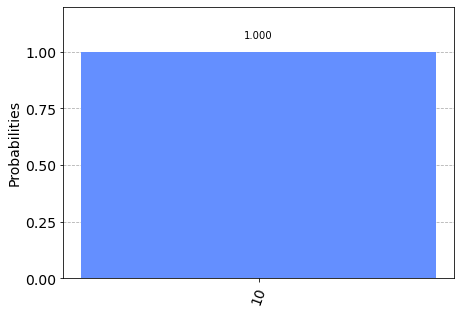

In [2]:
circ = QuantumCircuit(2)
circ.h(circ.qubits)


oracle = QuantumCircuit(2)
unitary = np.identity(4)
index_to_negate = 2
unitary[index_to_negate,index_to_negate] = -1
oracle.unitary(unitary,oracle.qubits)

diffuser = get_diffuser(2)

circ.append(oracle,circ.qubits)
circ.append(diffuser,circ.qubits)

circ.measure_all()

plot_histogram(execute_circ(circ,simulator).get_counts(circ))

## For any positive integer

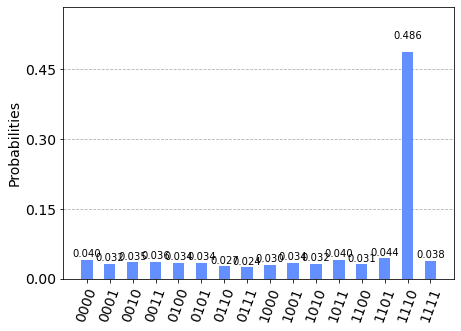

In [3]:
item = 14

item_binary = [*map(int,np.binary_repr(item))]
n = len(item_binary) # or np.ceil(np.log2(item+1))

circ = QuantumCircuit(n)
circ.h(circ.qubits)


oracle = QuantumCircuit(n)
unitary = np.identity(2**n)
index_to_negate = sum([i*2**k for k,i in enumerate(item_binary[::-1])])
unitary[index_to_negate,index_to_negate] = -1
oracle.unitary(unitary,oracle.qubits)

grover = get_grover_op(oracle=oracle)

circ.append(grover.to_gate(),circ.qubits)
circ.measure_all()

plot_histogram(execute_circ(circ,simulator).get_counts(circ))

## With qiskit algorithms package

In [16]:
# the state we desire to find
items = [6,8]
n = int(np.ceil(np.log2(max(items)+1)))

items_binary = [*map(lambda item: [*map(int,f'{np.binary_repr(item)[::-1]:0{n}}')],items)]


good_states = [*map(lambda x: ''.join(map(str,x)),items_binary)] #['0101', '0111', '1001', '1011', '1111']
good_states
# #https://qiskit.org/textbook/ch-algorithms/quantum-counting.html
oracle = QuantumCircuit(n)

# pOracle = PhaseOracle('x0 & ~x1 & x2 & ~x3 | x0 & x1 & x2 & ~x3 | x0 & ~x1 & ~x2 & x3| x0 & x1 & ~x2 & x3 | x0 & x1 & x2 & x3 ')

# oracle.append(pOracle.to_gate(), [0,1,2,3])

# # define Grover's algorithm
# problem = AmplificationProblem(oracle, is_good_state=good_states)


# grover = Grover(quantum_instance=simulator)
# result = grover.amplify(problem)
# answer = result.circuit_results
# plot_histogram(answer)

['0110', '0001']

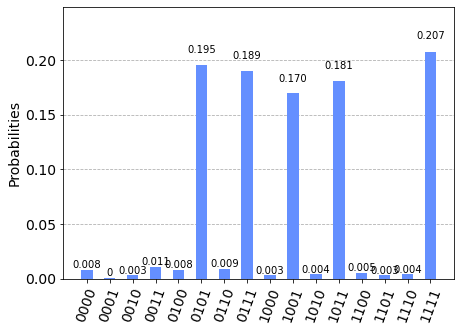

In [8]:
# the state we desire to find
items = [6,8]
n = int(np.ceil(np.log2(max(items)+1)))

items_binary = [*map(lambda item: [*map(int,f'{np.binary_repr(item)[::-1]:0{n}}')],items)]


good_states = ['0101', '0111', '1001', '1011', '1111']

#https://qiskit.org/textbook/ch-algorithms/quantum-counting.html
oracle = QuantumCircuit(4)

pOracle = PhaseOracle('x0 & ~x1 & x2 & ~x3 | x0 & x1 & x2 & ~x3 | x0 & ~x1 & ~x2 & x3| x0 & x1 & ~x2 & x3 | x0 & x1 & x2 & x3 ')

oracle.append(pOracle.to_gate(), [0,1,2,3])

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_states)


grover = Grover(quantum_instance=simulator)
result = grover.amplify(problem)
answer = result.circuit_results
plot_histogram(answer)